In [1]:
import sys
sys.path.append("/home/cbarkhof/code-thesis/NewsVAE/final-analysis")
from plot_style import *
%config InlineBackend.figure_format='retina'
%matplotlib inline

import numpy as np
from tqdm.auto import tqdm

import torch
import torch.nn.functional as F
from torch.distributions import constraints

import torch.distributions  as td

import pyro
import pyro.distributions as pd
from pyro.infer import Predictive, SVI, Trace_ELBO, TraceEnum_ELBO
from pyro.infer import config_enumerate, infer_discrete

from pyro.optim import ClippedAdam
from pyro import poutine

assert pyro.__version__.startswith('1.6.0')
pyro.set_rng_seed(0)

In [2]:
from tabulate import tabulate
from collections import namedtuple, OrderedDict

In [3]:
def moving_average(data_set, periods=3):
    weights = np.ones(periods) / periods
    return np.convolve(data_set, weights, mode='valid')

In [4]:
device = torch.device('cuda:0')

In [5]:
# D = 32
# S = 10000

In [6]:
# data_samples = [
#     td.Normal(torch.zeros(D), torch.ones(D)).sample((S,)),    
#     td.Normal(torch.zeros(D), torch.ones(D)).sample((S,)),    
#     td.Normal(torch.zeros(D), torch.ones(D)/2.).sample((S,)),
#     td.Normal(torch.zeros(D), torch.ones(D)*2.).sample((S,)),
#     td.Normal(td.Normal(0., 1.).sample((D,)), td.LogNormal(0., 1.).sample((D,))).sample((S,)),
#     td.Normal(td.Normal(0., 1.).sample((D,)), td.LogNormal(0., 1.).sample((D,))).sample((S,)),
#     td.LowRankMultivariateNormal(torch.zeros(D), td.Normal(0., 1.).sample((D,2)), td.LogNormal(0., 1.).sample((D,))).sample((S,)),
#     td.LowRankMultivariateNormal(td.Normal(1., 1.).sample((D,)), td.Normal(0., 1.).sample((D,2)), td.LogNormal(0., 1.).sample((D,))).sample((S,)),
#     td.LowRankMultivariateNormal(td.Normal(10., 2.).sample((D,)), td.Normal(0., 1.).sample((D,2)), td.LogNormal(0., 1.).sample((D,))).sample((S,)),
# ]

# Claartje: load latent data

In [7]:
import pickle
import numpy as np
import torch
import pandas

df = pandas.read_csv("Latent-analysis/Runs_overview.csv", index_col=0)

print("Different optimisation techniques:", df["optimisation"].unique())
print("Different target rates:", df["target_rate"].unique())

display(df.head())

def get_encodings(run_name):
    return pickle.load( open( f"Latent-analysis/Latent-data/{run_name}/all_validation_encodings.pickle", "rb" ) ) 

all_encodings = {}
for row_i, row in df.iterrows():
    
    encodings = get_encodings(row["run_name"])
    encodings = {k:v.numpy() for k, v in encodings.items() if torch.is_tensor(v)}
    
    all_encodings[row["clean_name"]] = {
        "run_name": row["run_name"],
        "optimisation": row["optimisation"],
        "target_rate": row["target_rate"]
    }
    
    all_encodings[row["clean_name"]] = {**all_encodings[row["clean_name"]], **encodings}
    
D = 32
S = 3370

data_samples = [torch.FloatTensor(d["latents"]) for _, d in all_encodings.items()]
data_samples = [torch.randn((S, D))] + data_samples

target_rates = [d["target_rate"] for _, d in all_encodings.items()]
target_rates = [0.0] + target_rates

opt_techniques = [d["optimisation"] for _, d in all_encodings.items()]
opt_techniques = ["prior"] + opt_techniques

group_names = [name for name, _ in all_encodings.items()]
group_names = ["prior"] + group_names


Different optimisation techniques: ['FB' 'VAE' 'MDR' 'CYC-FB' 'AE' 'CYC']
Different target rates: [0.25  0.5   0.    0.125 1.    0.75 ]


,run_name,mech_string,dataset_name,dataset,clean_name,target_rate,optimisation,drop,mem,emb,matrix,run_id,efficient_epochs,max pareto logged epoch,n_checkpoints,checkpoints
0,2021-05-20-rate-exp-fb-0.25-ptb-mem-emb-run-12...,mem+emb,PTB,PTB,PTB | FB | mem+emb | Target rate: 0.25,0.250,FB,0.0,True,True,False,2ub2onw0,"[5, 6, 7, 8, 9, 10, 11, 12, 13, 14]",14,10,['checkpoint-epoch-005-step-3510-iw-ll_089.pth...
1,2021-05-20-rate-exp-fb-0.5-ptb-mem-emb-run-22:...,mem+emb,PTB,PTB,PTB | FB | mem+emb | Target rate: 0.5,0.500,FB,0.0,True,True,False,1gjoso4t,"[5, 7, 8, 9, 10, 11, 13]",14,7,['checkpoint-epoch-005-step-3510-iw-ll_092.pth...
2,2021-05-21-PTB | VAE | memory-embeddings-run-0...,mem+emb,PTB,PTB,PTB | VAE | mem+emb | Target rate: 0.0,0.000,VAE,0.0,True,True,False,evvxxxs9,"[2, 4, 5, 6, 7, 8, 9, 10]",19,2,['checkpoint-epoch-006-step-2303-iw-ll_086.pth...
3,2021-05-21-rate-exp-fb-0.125-ptb-mem-emb-run-1...,mem+emb,PTB,PTB,PTB | FB | mem+emb | Target rate: 0.125,0.125,FB,0.0,True,True,False,ecxb7fjl,"[4, 5, 6, 7, 8, 9, 10, 11, 12, 13]",14,10,['checkpoint-epoch-004-step-2925-iw-ll_089.pth...
4,2021-05-21-rate-exp-fb-1.0-ptb-mem-emb-run-06:...,mem+emb,PTB,PTB,PTB | FB | mem+emb | Target rate: 1.0,1.000,FB,0.0,True,True,False,fik6meti,"[5, 9, 10, 11, 12, 13]",14,6,['checkpoint-epoch-005-step-3510-iw-ll_100.pth...


In [8]:
for x in data_samples:
    print(x.shape)

torch.Size([3370, 32])
torch.Size([3370, 32])
torch.Size([3370, 32])
torch.Size([3370, 32])
torch.Size([3370, 32])
torch.Size([3370, 32])
torch.Size([3370, 32])
torch.Size([3370, 32])
torch.Size([3370, 32])
torch.Size([3370, 32])
torch.Size([3370, 32])
torch.Size([3370, 32])
torch.Size([3370, 32])
torch.Size([3370, 32])
torch.Size([3370, 32])
torch.Size([3370, 32])
torch.Size([3370, 32])
torch.Size([3370, 32])
torch.Size([3370, 32])


In [9]:
# # [G, S, D]
# data = torch.stack(
#     (td.MultivariateNormal(torch.zeros(D), torch.eye(D)).sample([S]),
#      td.MultivariateNormal(torch.zeros(D), torch.eye(D)).sample([S]),
#      td.MultivariateNormal(torch.tensor([1.5, 2]), torch.eye(D)).sample([S]),
#      td.MultivariateNormal(td.Gamma(10., 2.).sample((D,)), td.Gamma(1., 10.).sample((D,)) * torch.eye(D)).sample([S]),
#      td.MultivariateNormal(8 * torch.ones(D), torch.eye(D)).sample([S]),     
#      )
# )
data = torch.stack([t.to(device) for t in data_samples])
G = data.shape[0]
print(f"G={G} S={S} D={D}")

G=19 S=3370 D=32


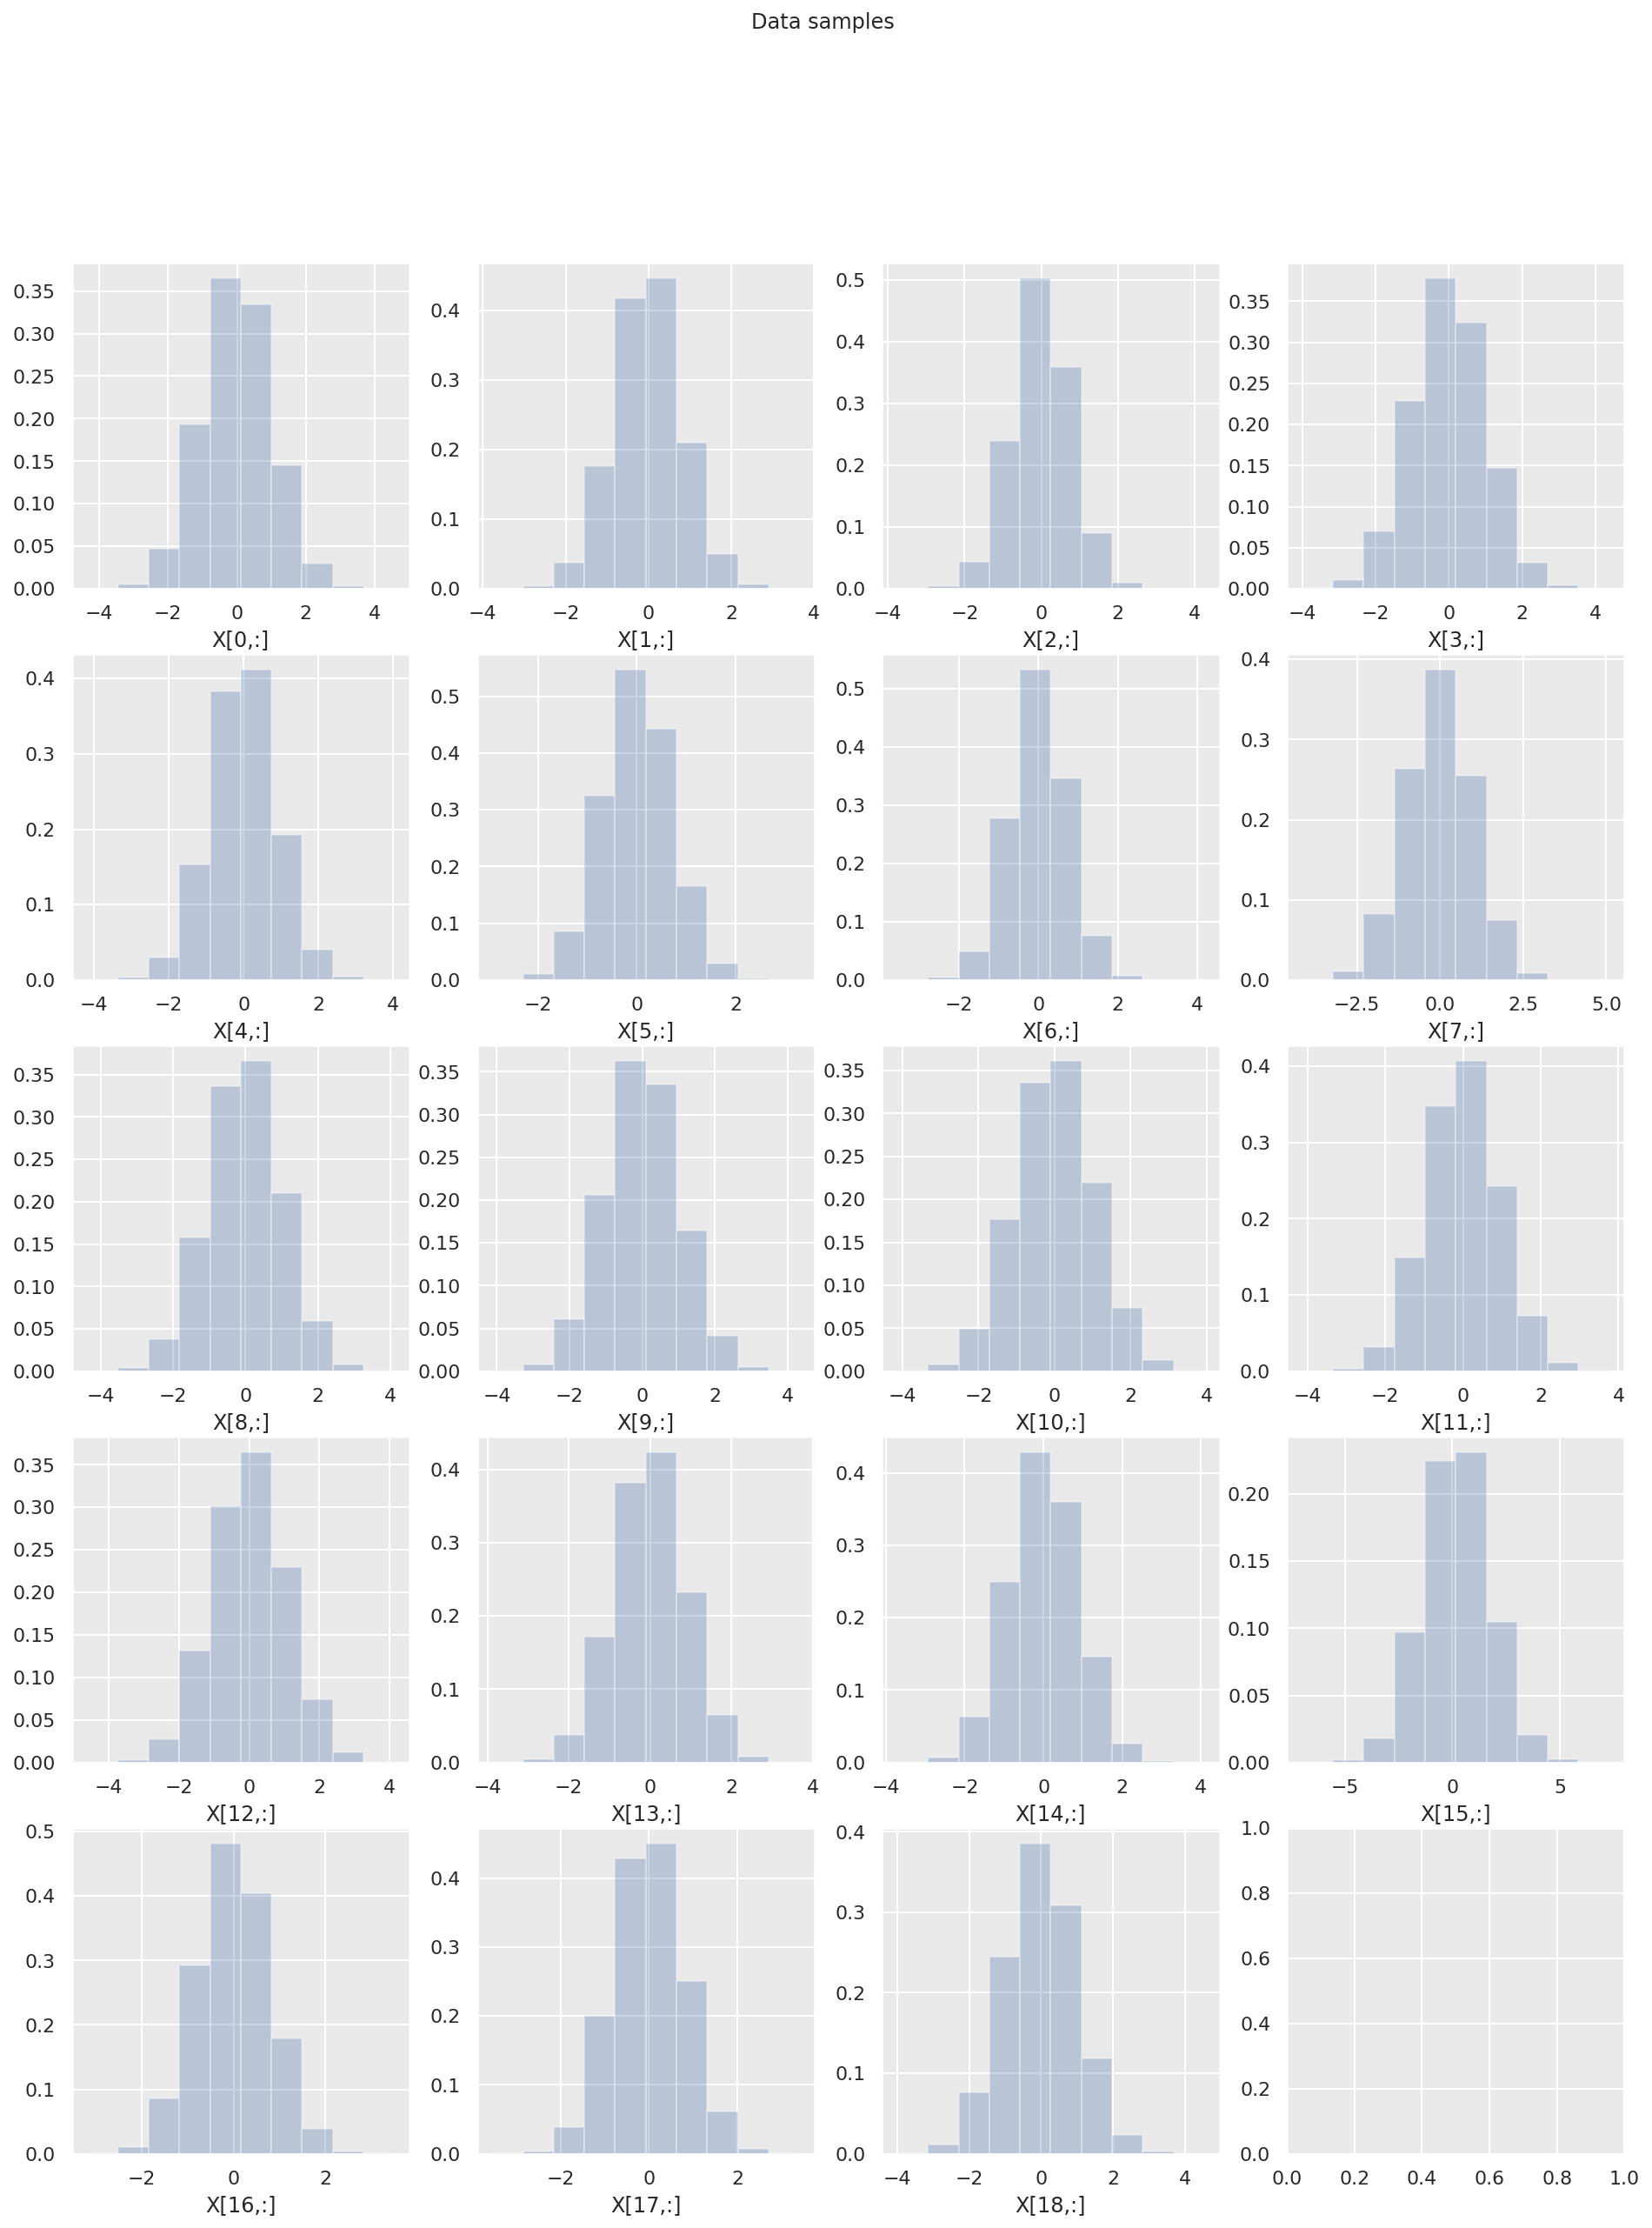

In [10]:
fig, ax = plt.subplots(ncols=4, nrows=G//4+bool(G%4), figsize=(16, 4*(G//4+bool(G%4))))
if len(ax.shape) == 1:
    ax = ax.reshape(1, -1)

for g in range(G):
    _ = ax[g//4, g%4].hist(data[g].flatten().cpu().numpy(), alpha=0.3, density=True, label=f"g={g}")
    _ = ax[g//4, g%4].set_xlabel(f"X[{g},:]")

fig.suptitle(f"Data samples")
fig.show()

In [56]:
cfg = OrderedDict(
    T=10, 
    prior_loc=0.0, 
    prior_cov_factor=0.0, 
    prior_cov_diag=1., 
    DP_alpha=0.01, 
    rank=2,
    device=device
)
cfg = namedtuple("Config", cfg.keys())(*cfg.values())
cfg

Config(T=10, prior_loc=0.0, prior_cov_factor=0.0, prior_cov_diag=1.0, DP_alpha=0.01, rank=2, device=device(type='cuda', index=0))

In [57]:
def mix_weights(beta):
    beta1m_cumprod = (1 - beta).cumprod(-1)
    return F.pad(beta, (0, 1), value=1) * F.pad(beta1m_cumprod, (1, 0), value=1)

In [58]:
#L = td.LKJCholesky(5, 1000).sample()
#L.T @ L

In [59]:
#td.LowRankMultivariateNormal(torch.zeros(3), torch.zeros([3, 3]), torch.ones(3)).covariance_matrix

In [60]:
@config_enumerate
def model(x):
    """
    covariance_matrix = A.T @ A + diag(B)
    
    Base:
        A[1:D] ~ N(0,1)
        B[1:D] ~ Gamma(10,10) or LogNormal(0,0.1)
        
        
    for t in [T]:
        Dist[t] ~ Base()
    for g in [G]:
        w[g] ~ Stickbreaking(alpha)
        for n in [N[g]]:
            for d in [D]:
                z[g,n,d] ~ Cat(w[g])
                x[g,n,d] ~ Dist[z[g,n]]
    """

    G, S, D = x.shape
    N = S * D
    # [N, G, 1]    
    obs = x.reshape(G, N, 1).transpose(1, 0)
    assert obs.shape == (N, G, 1), f"Got {obs.shape} instead of {(N, G, 1)}"
    
    # Sample Gaussian Components
    with pyro.plate("components", cfg.T, device=cfg.device):
        # [T, D]
        #prior_loc = torch.full([D], cfg.prior_loc)
        # [T, D, R]
        #prior_cov_factor = cfg.prior_cov_factor + torch.zeros((D, cfg.rank))
        # [T, D]
        #prior_cov_diag = cfg.prior_diag + torch.zeros(D)
        
        mu = pyro.sample("mu", pd.Independent(pd.Normal(torch.zeros(1).to(device), torch.ones(1).to(device)), 1))
        mu = torch.sort(mu, -2).values
        #C = pyro.sample("C", pd.Independent(pd.Normal(torch.zeros(D, cfg.rank).to(device), torch.ones(D, cfg.rank).to(device)), 2))
        diag = pyro.sample("diag", pd.Independent(pd.Gamma(torch.ones(1).to(device)*10., torch.ones(1).to(device)*10), 1))
        
        nu = pyro.sample("nu", pd.Independent(pd.Exponential(torch.ones(1).to(device)), 1))
        
        #mu = pyro.param("mu", td.Normal(torch.zeros(D), torch.ones(D)).sample((cfg.T,)))
        #C = pyro.param("C", td.Normal(torch.zeros(D, cfg.rank), torch.ones(D, cfg.rank)).sample((cfg.T,)))
        #diag = pyro.param("diag", td.LogNormal(torch.zeros(D), torch.ones(D)*0.25).sample((cfg.T,)), constraint=constraints.positive)
        
        # [T, D]
        #mu = pyro.sample("mu", pd.LowRankMultivariateNormal(prior_loc, prior_cov_factor, prior_cov_diag))
        # [T, D]
        #sigma = pyro.sample("sigma", pd.Independent(pd.Gamma(torch.ones(D), torch.ones(D)), 1))
        
    # Sample mixing weights
    with pyro.plate("sticks", cfg.T-1, device=cfg.device):
        with pyro.plate("DPs", G, device=cfg.device):
            # [G, T-1]
            beta = pyro.sample("beta", pd.Beta(torch.ones(1).to(device), cfg.DP_alpha))
            # [G, T]
            omega = pyro.deterministic("omega", mix_weights(beta))

    # Sample observations
    with pyro.plate("group", G, device=cfg.device):
        with pyro.plate("data", N, device=cfg.device):
            # [S, G]
            z = pyro.sample("z", pd.Categorical(probs=omega))

            # [S, G, D]
            loc = mu[z]
            scale = diag[z]
            # [S, G, D, D]
            #cov = torch.diag_embed(sigma[z])
            #cov_factor = C[z]
            #cov_diag = diag[z]
            # mu: [S, G, D]
            #pyro.sample("obs", pd.Normal(loc, scale).to_event(1), obs=obs)
            pyro.sample("obs", pd.StudentT(nu[z], loc, scale).to_event(1), obs=obs)


In [61]:
#trace = poutine.trace(model).get_trace()
trace = poutine.trace(poutine.enum(model, first_available_dim=-3)).get_trace(data)
trace.compute_log_prob()
print(trace.format_shapes())

  Trace Shapes:                         
   Param Sites:                         
  Sample Sites:                         
components dist                  |      
          value               10 |      
       log_prob                  |      
        mu dist               10 |  1   
          value               10 |  1   
       log_prob               10 |      
      diag dist               10 |  1   
          value               10 |  1   
       log_prob               10 |      
        nu dist               10 |  1   
          value               10 |  1   
       log_prob               10 |      
    sticks dist                  |      
          value                9 |      
       log_prob                  |      
       DPs dist                  |      
          value               19 |      
       log_prob                  |      
      beta dist        19      9 |      
          value        19      9 |      
       log_prob        19      9 |      
     omega dist 

In [62]:
def guide(x):
    G, S, D = x.shape
    
    # [G, T-1]
    kappa = pyro.param('kappa', td.Uniform(0, 2).sample([G, cfg.T-1]).to(device), constraint=constraints.positive)
    
    # [T, D]
    m = pyro.param('m', td.Normal(torch.zeros(1), torch.ones(1) * 3).sample([cfg.T]).to(device))
    
    # [T, D]
    s = F.softplus(pyro.param('s', td.Normal(torch.zeros(1), torch.ones(1) * 3).sample([cfg.T]).to(device)))
    
    # [T, D, R]
    #M = pyro.param('M', td.Normal(torch.zeros(D, cfg.rank), torch.ones(D, cfg.rank) * 3).sample([cfg.T]).to(device))    
    #S = pyro.param('S', td.Normal(torch.zeros(D, cfg.rank), torch.ones(D, cfg.rank) * 3).sample([cfg.T]).to(device))
    
    
    # [T, D]
    a = pyro.param('a', td.Normal(torch.zeros(1), torch.ones(1)).sample([cfg.T]).to(device))
    # [T, D]
    b = F.softplus(pyro.param('b', td.Normal(torch.ones(1)/2., torch.ones(1)/2.).sample([cfg.T]).to(device)))
    
    # [T, D]
    c = pyro.param('c', td.Normal(torch.zeros(1), torch.ones(1)).sample([cfg.T]).to(device))
    # [T, D]
    d = F.softplus(pyro.param('d', td.Normal(torch.ones(1)/2., torch.ones(1)/2.).sample([cfg.T]).to(device)))

    with pyro.plate("components", cfg.T):
        # [T, D]
        mu = pyro.sample("mu", pd.Independent(pd.Normal(m, s), 1))
        #mu = torch.sort(mu, -2).values
        #C = pyro.sample("C", pd.Independent(pd.Normal(M, F.softplus(S)), 2) )
        diag = pyro.sample("diag", pd.Independent(pd.LogNormal(a, b), 1))        
        nu = pyro.sample("nu", pd.Independent(pd.LogNormal(c, d), 1))        

    with pyro.plate("sticks", cfg.T-1):
        with pyro.plate("DPs", G):
            # [G, T-1]
            beta = pyro.sample("beta", pd.Beta(torch.ones(1, device=device), kappa))


In [63]:
#trace = poutine.trace(poutine.enum(guide, first_available_dim=-3)).get_trace(data)
#print(trace.format_shapes())

In [64]:
trace = poutine.trace(guide).get_trace(data)
trace.compute_log_prob()
print(trace.format_shapes())

  Trace Shapes:          
   Param Sites:          
          kappa    19 9  
              m    10 1  
              s    10 1  
              a    10 1  
              b    10 1  
              c    10 1  
              d    10 1  
  Sample Sites:          
components dist       |  
          value    10 |  
       log_prob       |  
        mu dist    10 | 1
          value    10 | 1
       log_prob    10 |  
      diag dist    10 | 1
          value    10 | 1
       log_prob    10 |  
        nu dist    10 | 1
          value    10 | 1
       log_prob    10 |  
    sticks dist       |  
          value     9 |  
       log_prob       |  
       DPs dist       |  
          value    19 |  
       log_prob       |  
      beta dist 19  9 |  
          value 19  9 |  
       log_prob 19  9 |  


In [65]:
optim = ClippedAdam({"lr": 0.01, "clip_norm": 10.0})
#svi = SVI(model, guide, optim, loss=Trace_ELBO())
elbo = TraceEnum_ELBO(max_plate_nesting=2)
svi = SVI(model, guide, optim, loss=elbo)
losses = []

def train(num_iterations):
    pyro.clear_param_store()
    iterator = tqdm(range(num_iterations))
    for j in iterator:
        loss = svi.step(x=data)
        losses.append(loss)
        iterator.set_postfix(OrderedDict(ELBO=-loss))

In [66]:
train(1000)

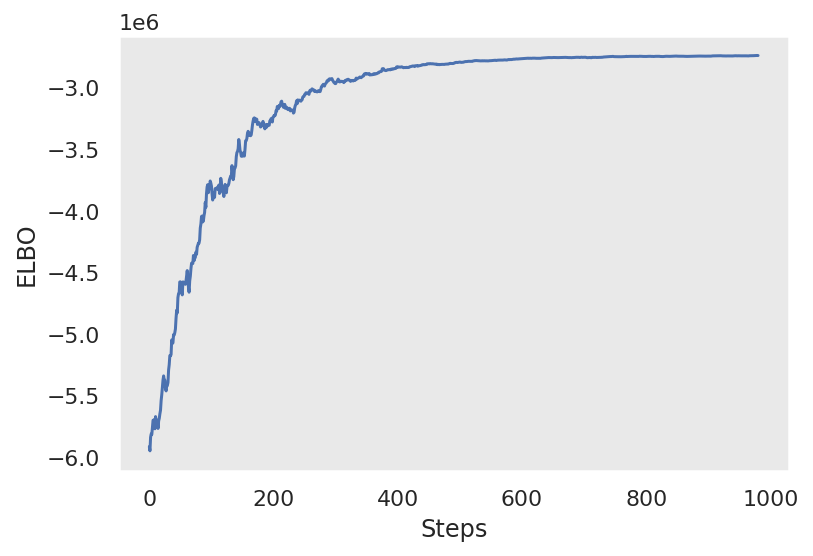

In [67]:
_ = plt.plot(moving_average(-np.array(losses), 20))
_ = plt.xlabel("Steps")
_ = plt.ylabel("ELBO")

In [68]:
# Using pyro's built in posterior predictive class
posterior = Predictive(guide, num_samples=1000)(data)

In [69]:
print(tabulate([[rv, rv_t.shape] for rv, rv_t in posterior.items()]))

----  ----------------------------
mu    torch.Size([1000, 1, 10, 1])
diag  torch.Size([1000, 1, 10, 1])
nu    torch.Size([1000, 1, 10, 1])
beta  torch.Size([1000, 19, 9])
----  ----------------------------


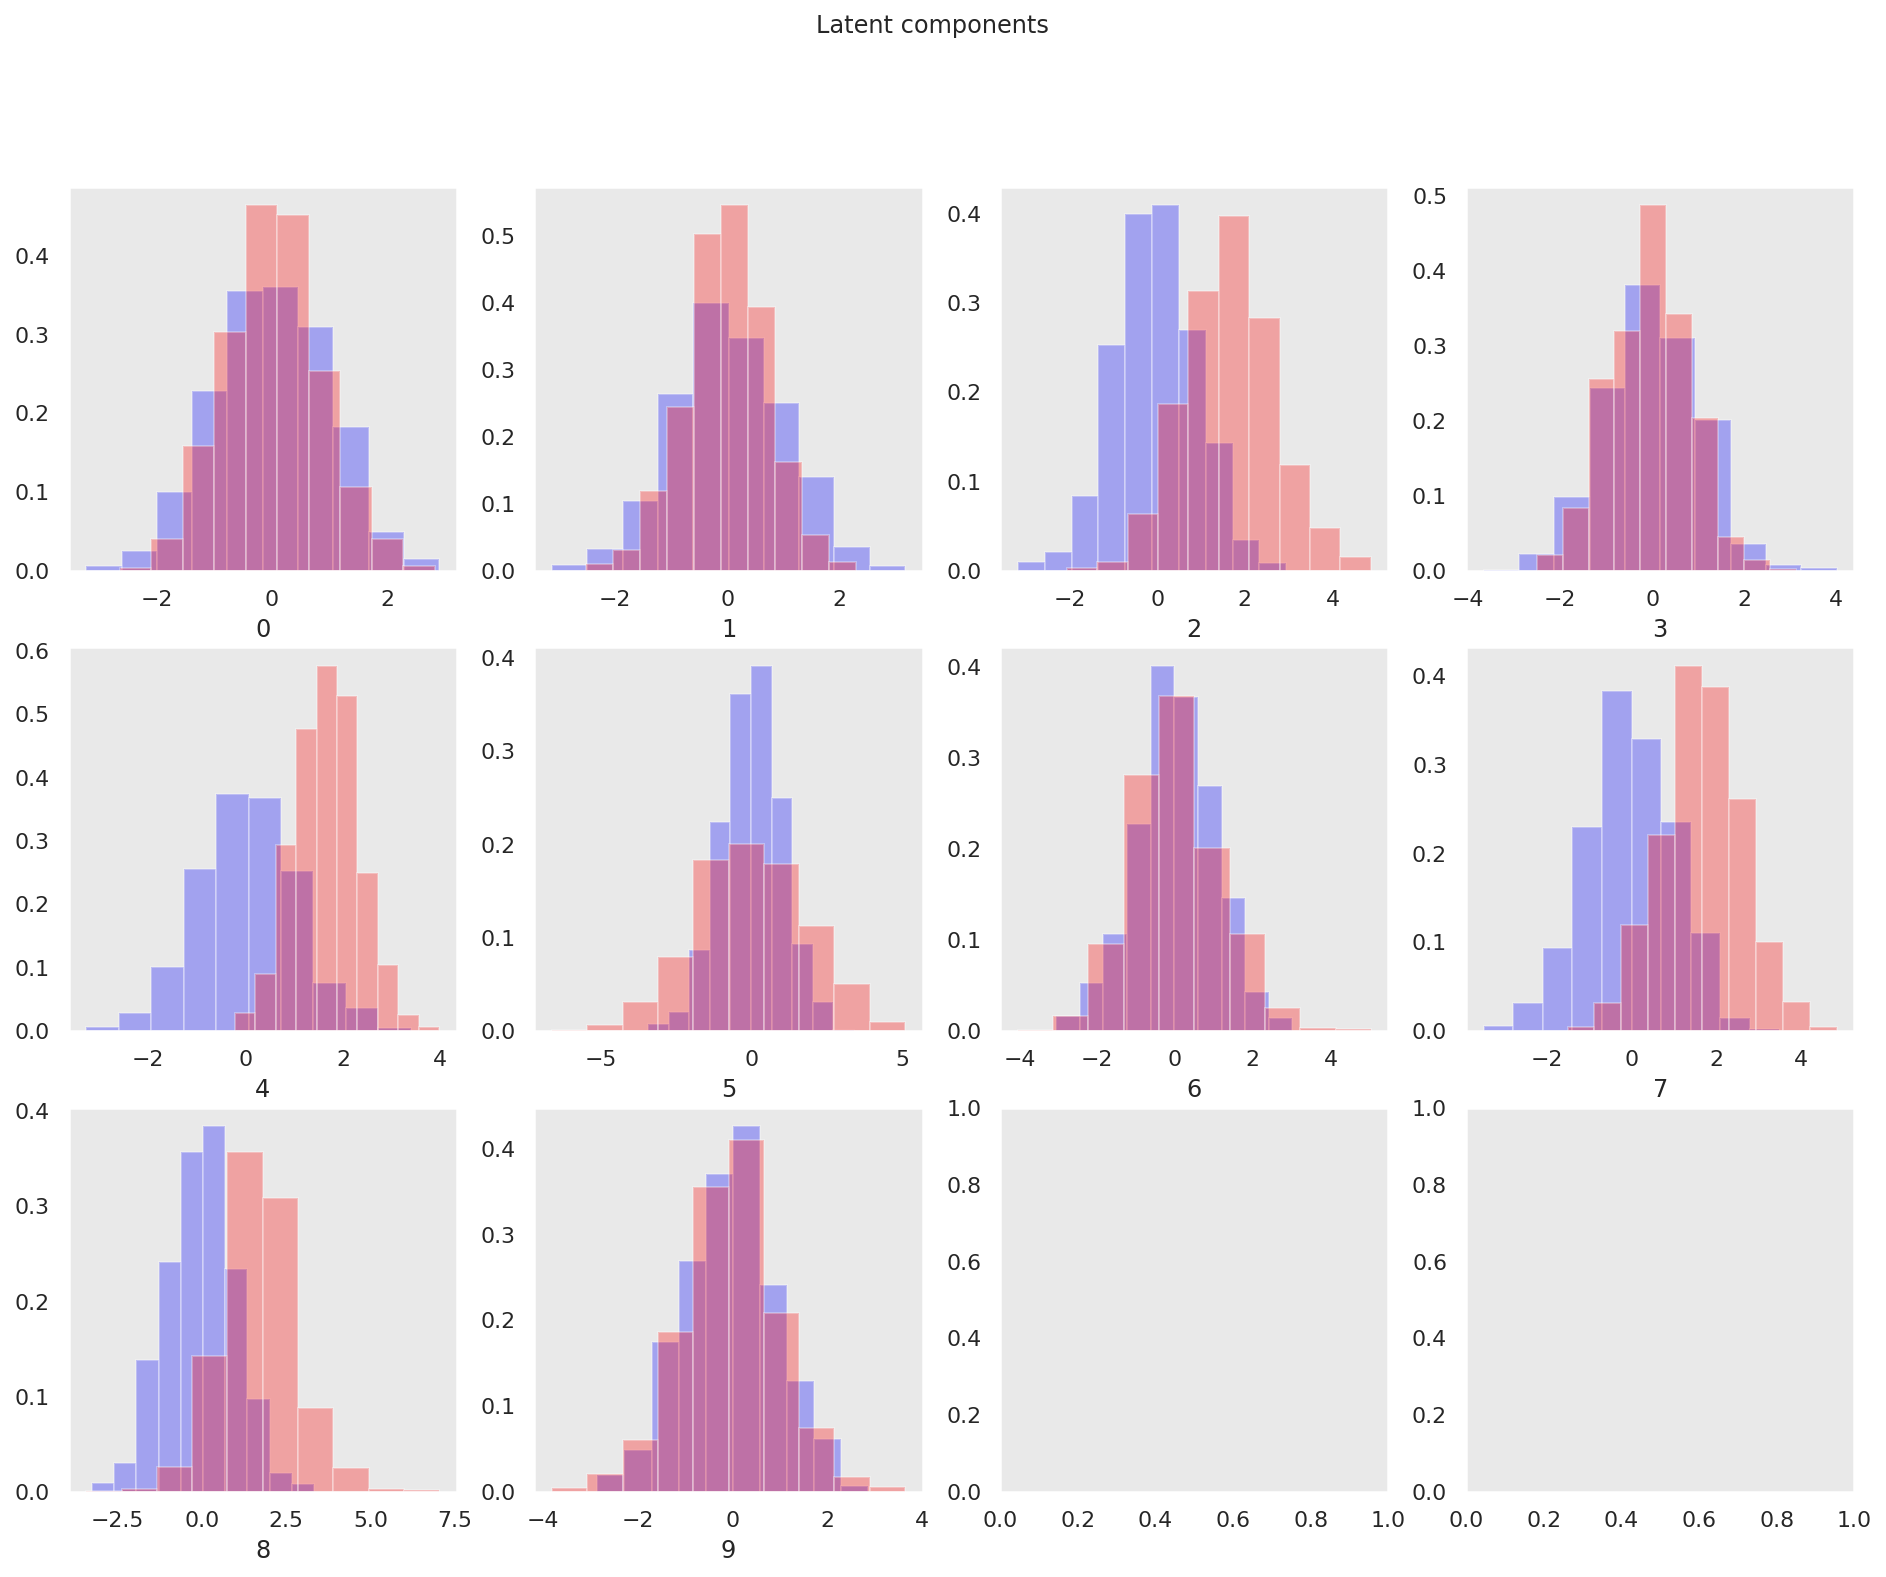

In [70]:
fig, ax = plt.subplots(ncols=4, nrows=cfg.T//4+bool(cfg.T%4), figsize=(16, 4*(cfg.T//4+bool(cfg.T%4))))

if len(ax.shape) == 1:
    ax = ax.reshape(1, -1)

fig.suptitle(f"Latent components")

for t in range(cfg.T):
    comp = td.Normal(posterior["mu"][:,:,t], posterior["diag"][:,:,t])
    x_ = comp.sample().detach().cpu().numpy()
    x0 = td.Normal(0, 1).sample(x_.shape).cpu().numpy()
    
    
    _ = ax[t//4, t%4].hist(x0.flatten(), alpha=0.3, density=True, color='blue')
    _ = ax[t//4, t%4].hist(x_.flatten(), alpha=0.3, density=True, color='red')
    _ = ax[t//4, t%4].set_xlabel(f"{t}")    
    
fig.show()

In [71]:
omega = mix_weights(posterior["beta"])
omega.shape

torch.Size([1000, 19, 10])

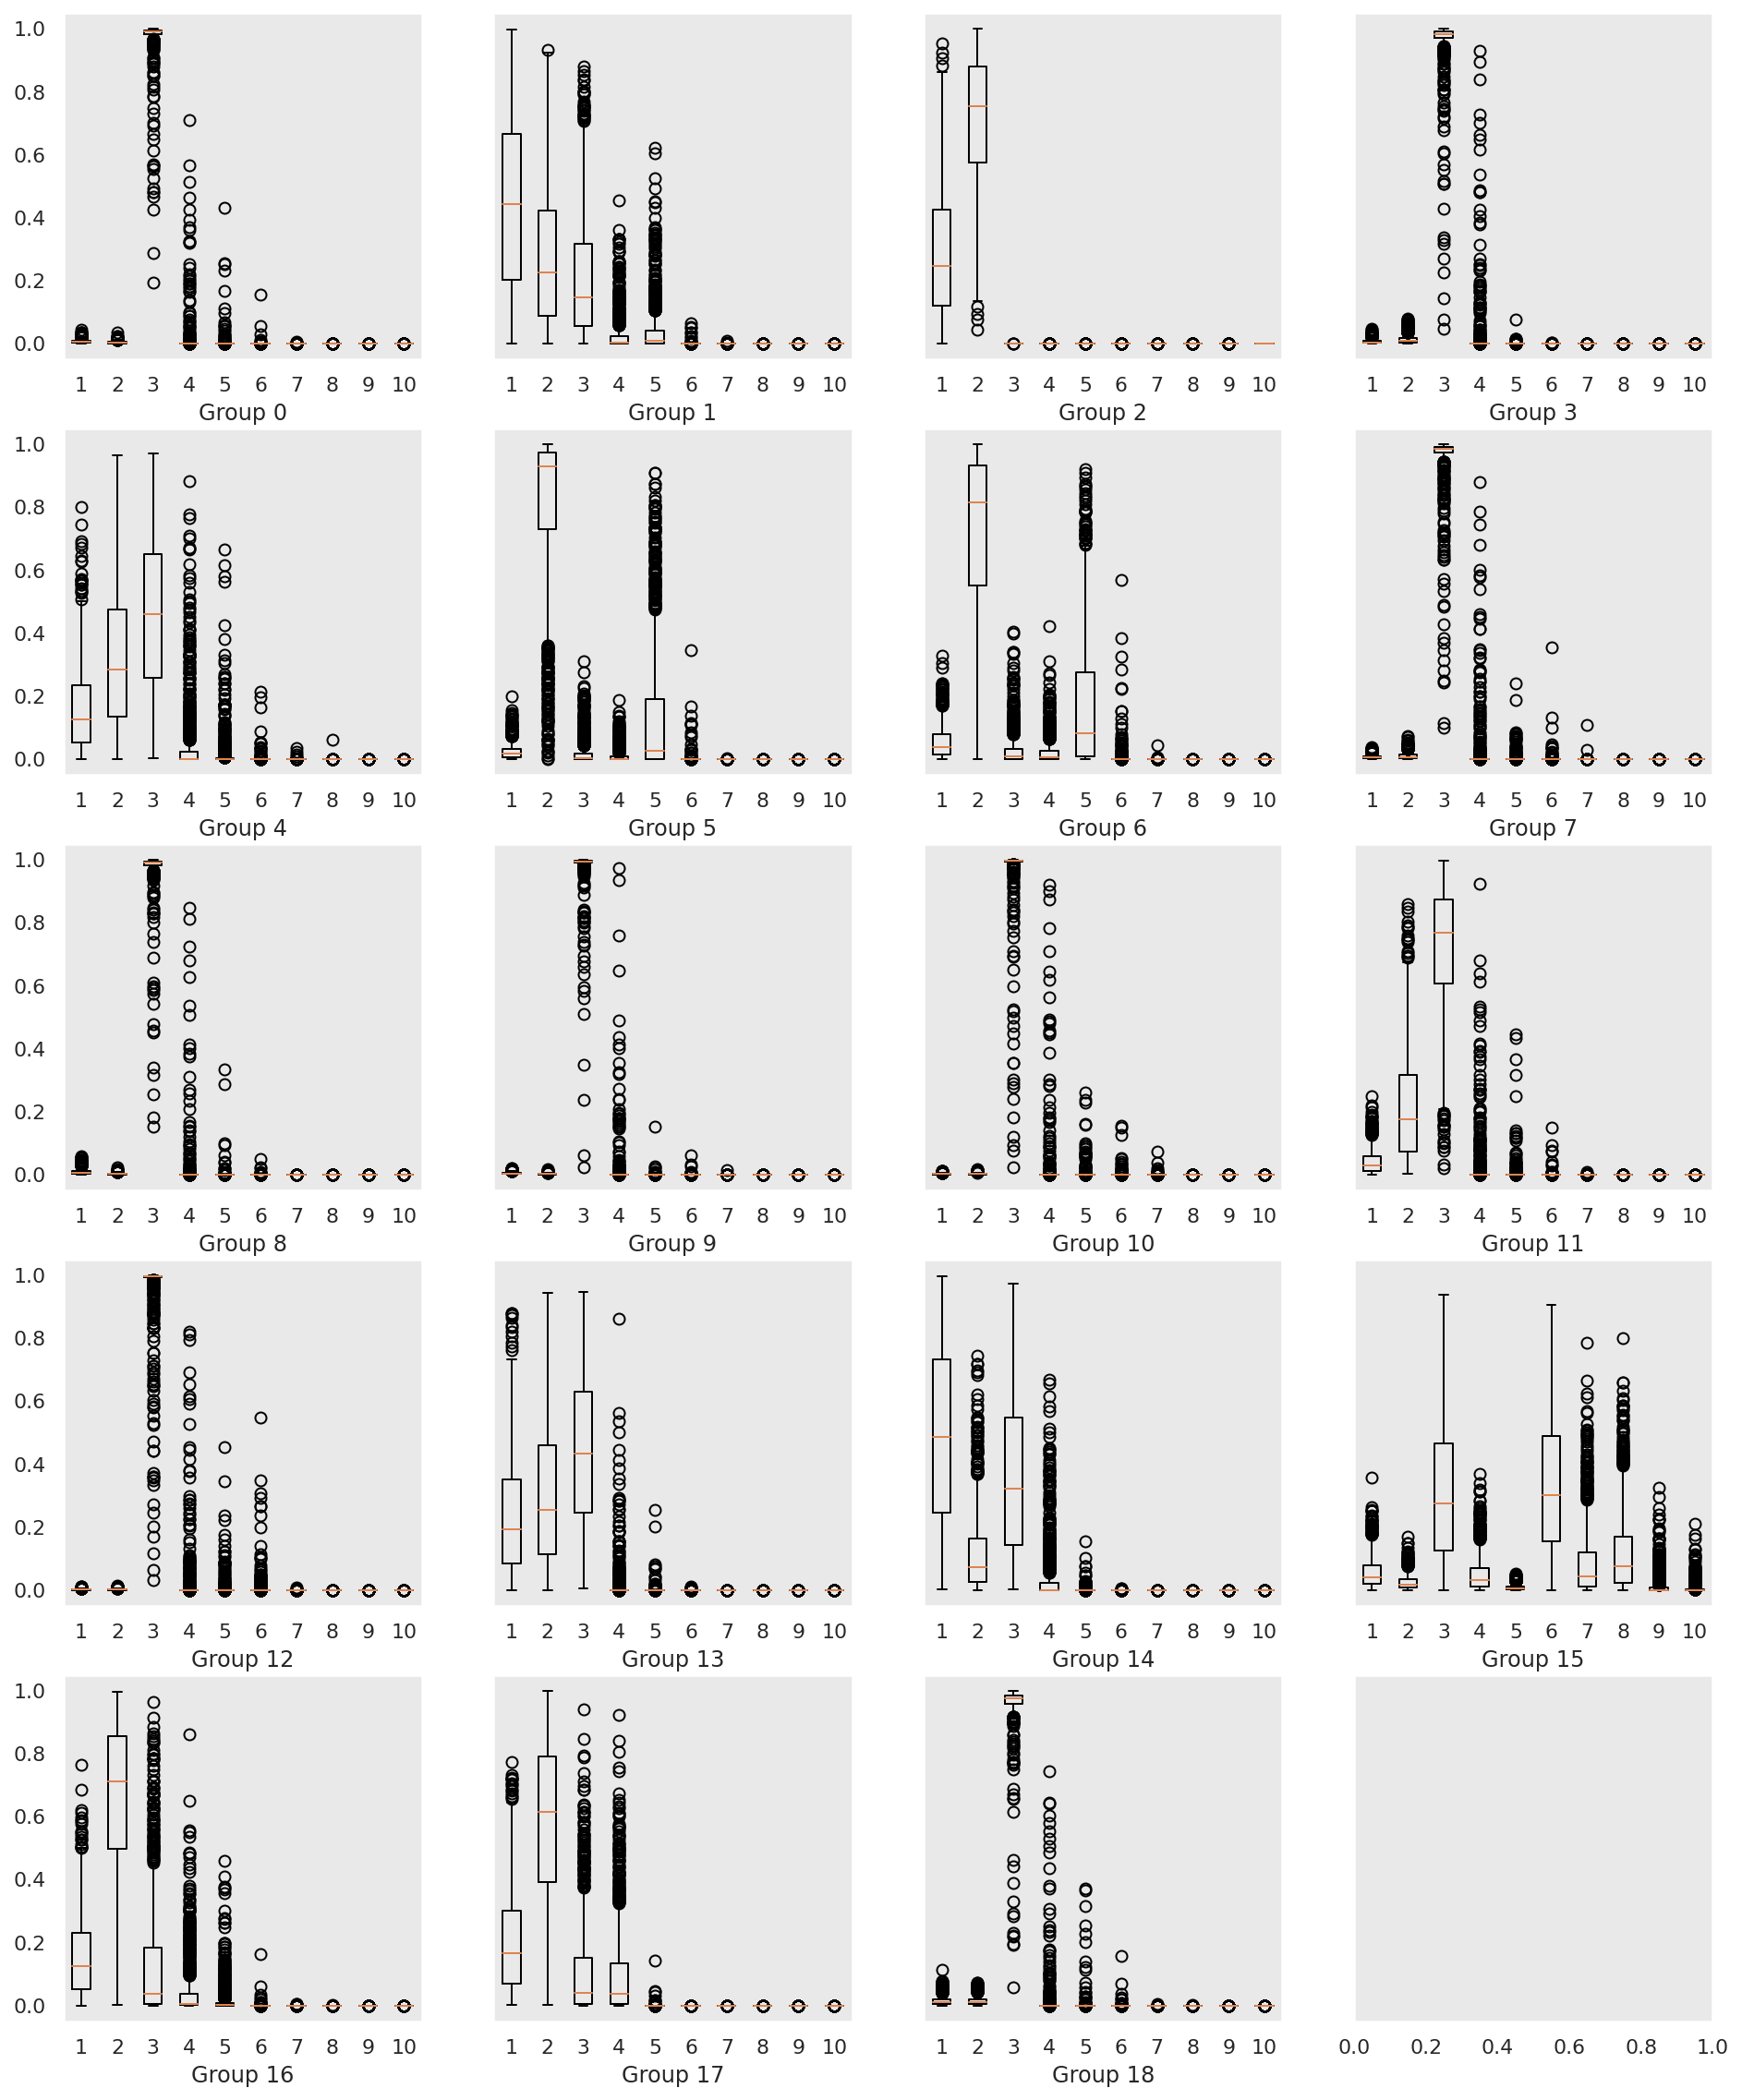

In [72]:
fig, ax = plt.subplots(ncols=4, nrows=G//4+bool(G%4), sharey=True, figsize=(16, 4*(G//4+bool(G%4))))

if len(ax.shape) == 1:
    ax = ax.reshape(1, -1)

for g in range(G):
    _ = ax[g//4, g%4].boxplot(omega[:,g,:].detach().cpu().numpy())
    _ = ax[g//4, g%4].set_xlabel(f"Group {g}")
fig.show()

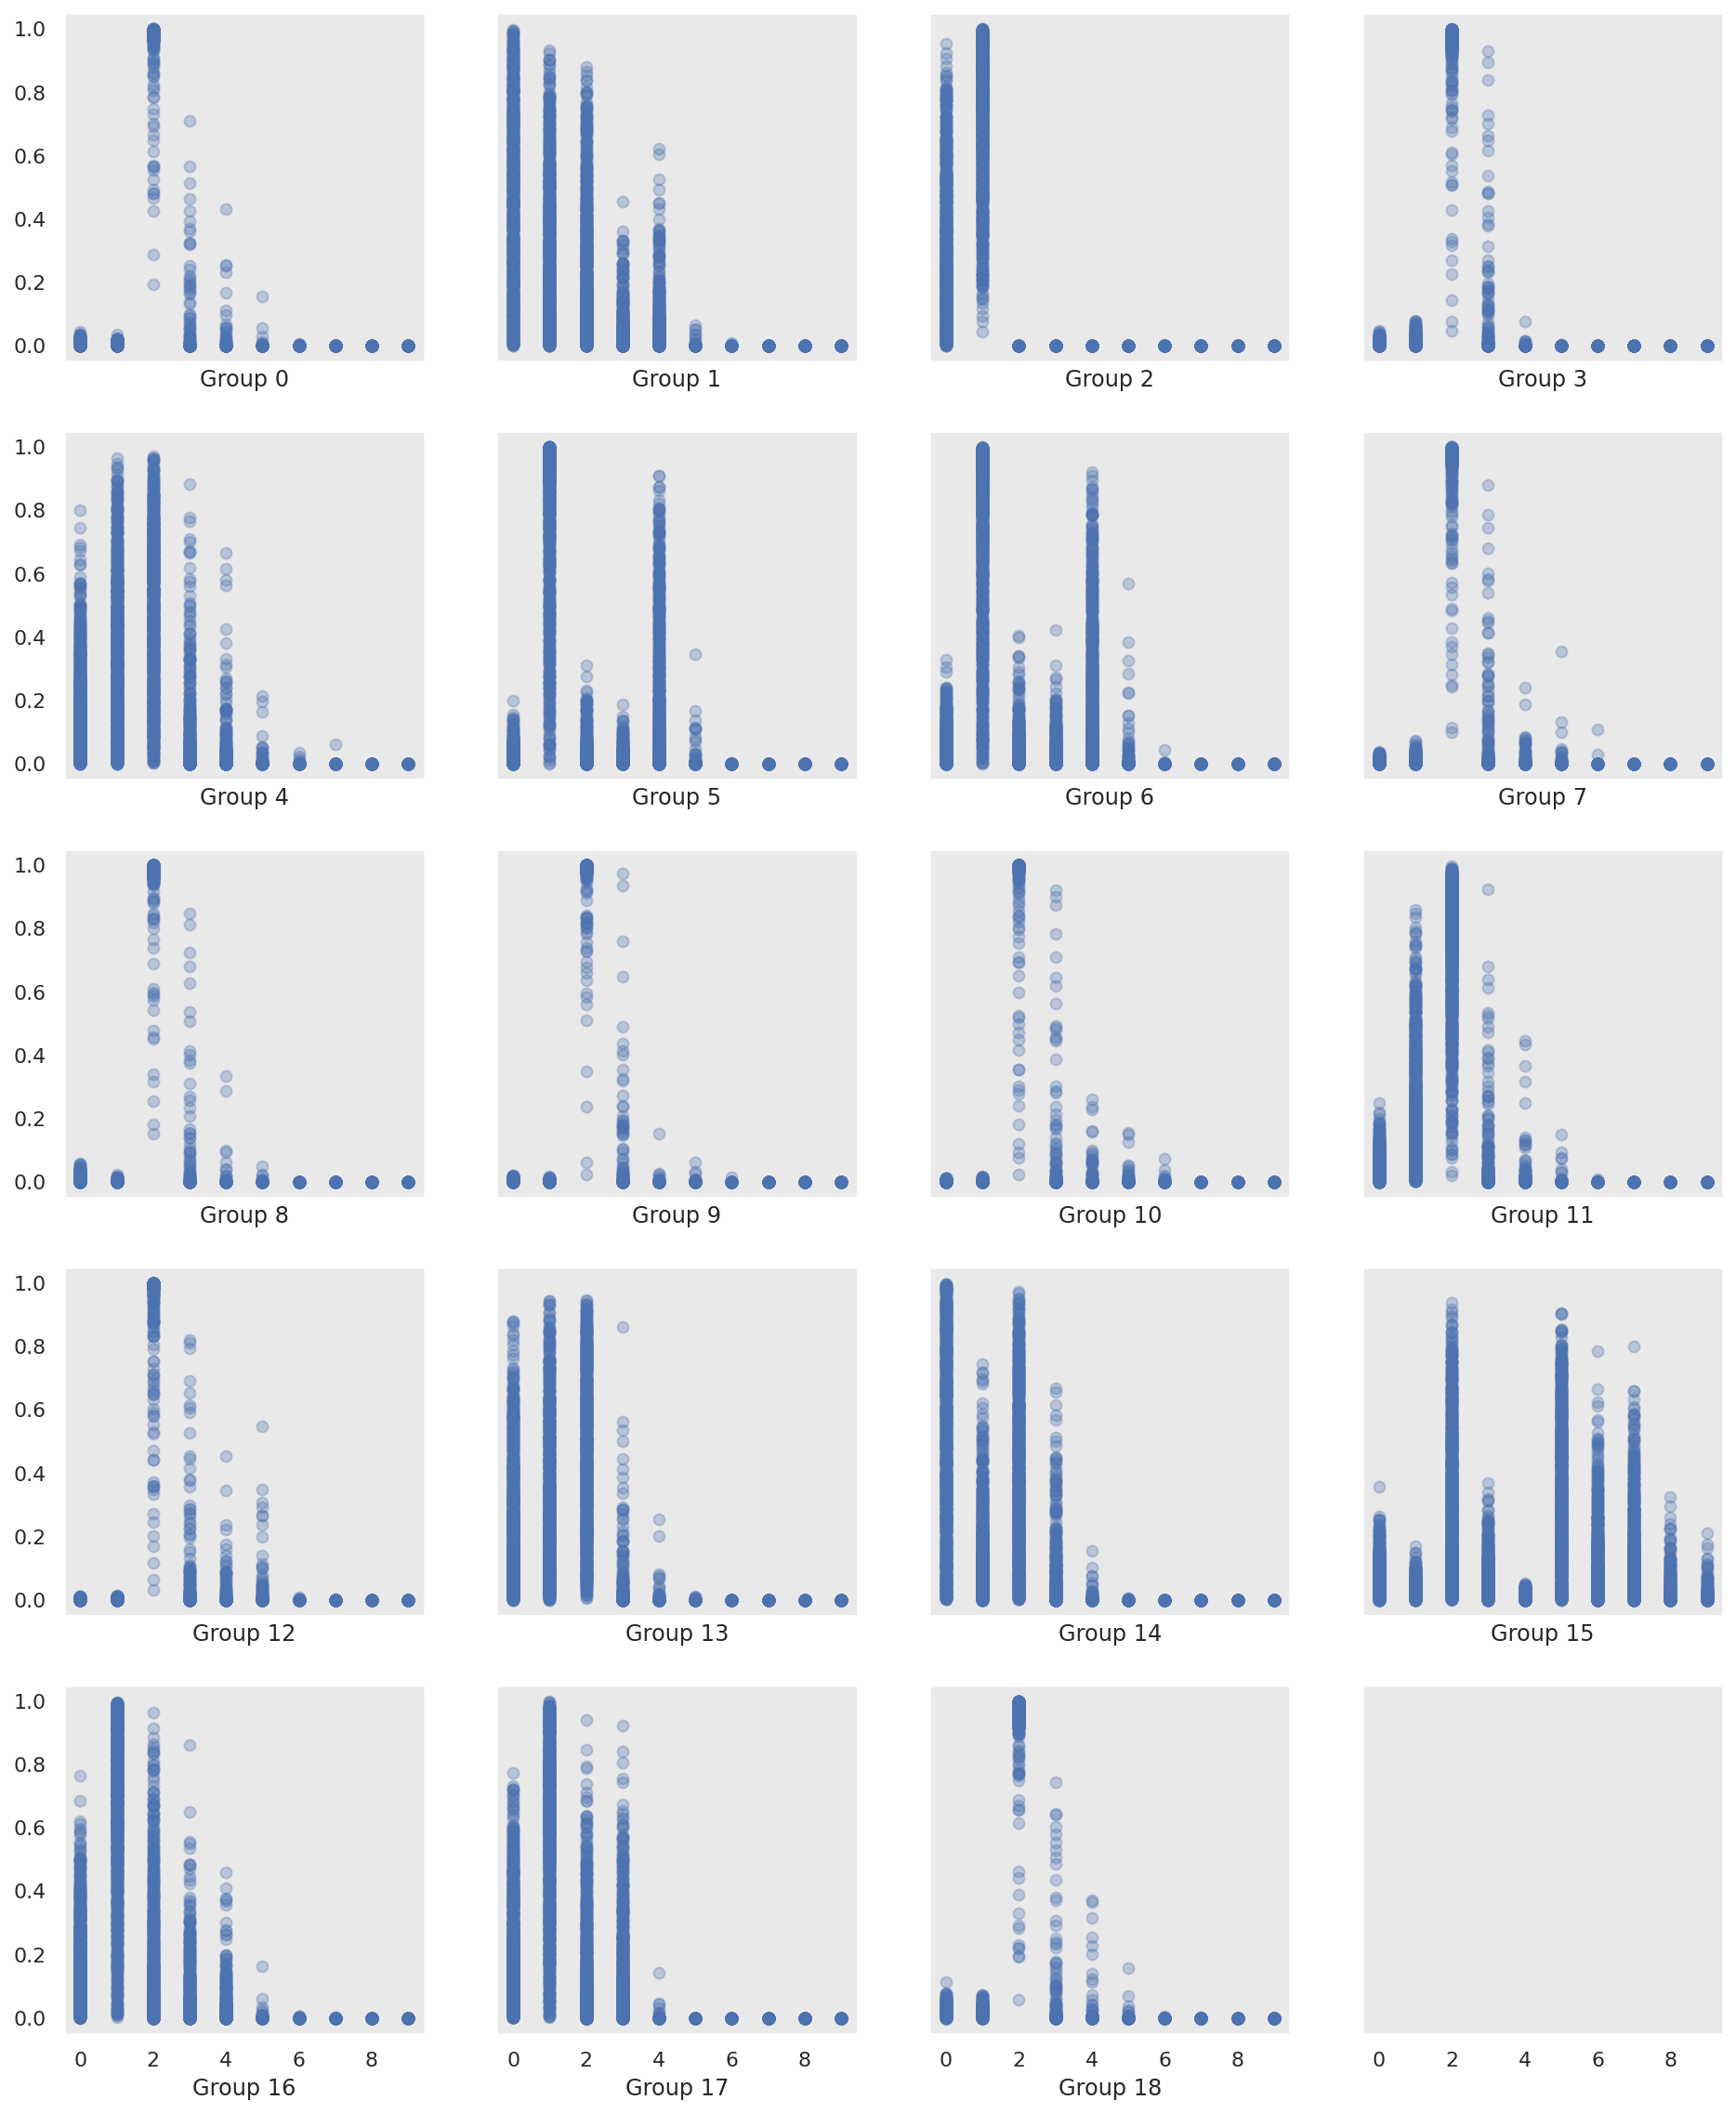

In [73]:
fig, ax = plt.subplots(ncols=4, nrows=G//4+bool(G%4), sharex=True, sharey=True, figsize=(16, 4*(G//4+bool(G%4))))

if len(ax.shape) == 1:
    ax = ax.reshape(1, -1)

for g in range(G):
    _ = ax[g//4, g%4].plot(
        torch.arange(cfg.T).expand(omega.shape).detach().cpu().numpy()[:,g,:].flatten(),
        omega.detach().cpu().numpy()[:,g,:].flatten(),
        'o',
        alpha=0.3
    )
    _ = ax[g//4, g%4].set_xlabel(f"Group {g}")
fig.show()

In [74]:
omega.shape

torch.Size([1000, 19, 10])

In [75]:
group_names_ordered = [
 'prior',
 'PTB | VAE | mem+emb | Target rate: 0.0',
 'PTB | AE | mem+emb | Target rate: 0.0',
 'PTB | CYC | mem+emb | Target rate: 0.0',
 'PTB | FB | mem+emb | Target rate: 0.125',
 'PTB | FB | mem+emb | Target rate: 0.25',
 'PTB | FB | mem+emb | Target rate: 0.5',
 'PTB | FB | mem+emb | Target rate: 0.75',
 'PTB | FB | mem+emb | Target rate: 1.0',
 'PTB | MDR | mem+emb | Target rate: 0.125',
 'PTB | MDR | mem+emb | Target rate: 0.25',
 'PTB | MDR | mem+emb | Target rate: 0.5',
 'PTB | MDR | mem+emb | Target rate: 0.75',
 'PTB | MDR | mem+emb | Target rate: 1.0',
 'PTB | CYC-FB | mem+emb | Target rate: 0.125',
 'PTB | CYC-FB | mem+emb | Target rate: 0.25',
 'PTB | CYC-FB | mem+emb | Target rate: 0.5',
 'PTB | CYC-FB | mem+emb | Target rate: 0.75',
 'PTB | CYC-FB | mem+emb | Target rate: 1.0']

group_names_ordered_clean_names = [
 'Prior',
 'VAE',
 'AE',
 'CYC',
 'FB - tr: 0.13',
 '         tr: 0.25',
 '         tr: 0.50',
 '         tr: 0.75',
 '         tr: 1.00',
 'MDR - tr: 0.13',
 '         tr: 0.25',
 '         tr: 0.50',
 '         tr: 0.75',
 '         tr: 1.00',
 'CYC-FB - tr: 0.13',
 '         tr: 0.25',
 '         tr: 0.50',
 '         tr: 0.75',
 '         tr: 1.00']

len(group_names_ordered_clean_names), len(group_names_ordered)

(19, 19)

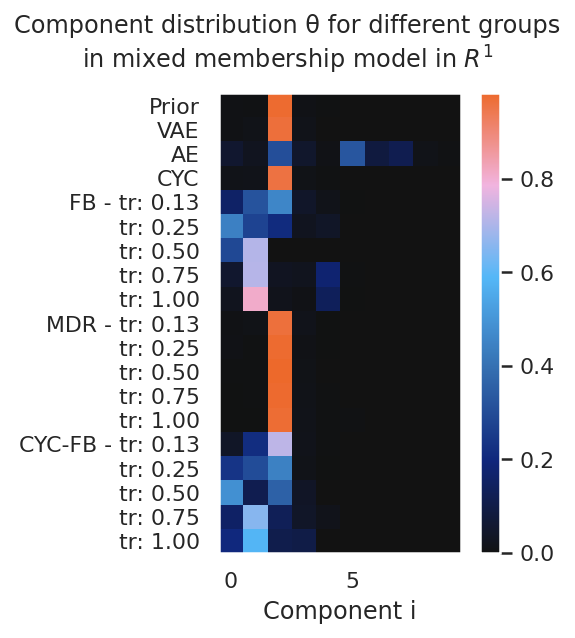

In [82]:
from matplotlib import pyplot as plt
plt.rcParams["axes.grid"] = False

omega_avg = omega.mean(0).detach().cpu().numpy()

omega_ordered = []
for gn in group_names_ordered:
    old_idx = group_names.index(gn)
    omega_ordered.append(omega_avg[old_idx, :])

omega_ordered = np.stack(omega_ordered)

fig, axs = plt.subplots(ncols=2, gridspec_kw={'width_ratios': [1, 0.05]}, figsize=(4, 4))
im = axs[0].imshow(omega_ordered, cmap=cmap)

axs[0].set_yticks(range(G))
axs[0].set_yticklabels(group_names_ordered_clean_names)
axs[0].set_xlabel("Component i")

plt.colorbar(im, cax=axs[1])
plt.tight_layout()
plt.suptitle("Component distribution θ for different groups\nin mixed membership model in $R^1$", y=1.1)
#plt.axis('off')
plt.savefig("plots/MMM_R1_component_plot.png", dpi=300, bbox_inches="tight")
plt.show()

In [77]:
import math

def sample_log_likelihood(latent_z, mu=None, logvar=None, reduce_latent_dim=True, reduce_batch_dim=True):
    """
    This function calculates the log likelihood of samples under the Normal
    Distribution, either parameterised by mu, logvar (posterior), else under the standard Normal (prior).
    """

    # Multi sample posterior case
    if latent_z.dim() == 3 and mu is not None and logvar is not None:
        if mu.dim() != 3:
            mu = mu.unsqueeze(1)
        if logvar.dim() != 3:
            logvar = logvar.unsqueeze(1)

    # Under a posterior z under q(z|x)
    if logvar is not None and mu is not None:
        # N(z| mu, sigma) = [-1 / 2(log var + log 2pi + (x - mu) ^ 2 / var)]
        var = logvar.exp()
        likelihood = (- 0.5 * (logvar + math.log(2 * math.pi) + ((latent_z - mu) ** 2 / var)))

    # Under a prior
    else:
        # N(z | 0, 1) = [-1/2 ( log 2pi + x^2)]
        likelihood = - 0.5 * (math.log(2 * math.pi) + (latent_z ** 2))

    # Reduce the latent dimension (log sum)
    if reduce_latent_dim:
        likelihood = likelihood.sum(dim=-1)

    if reduce_batch_dim:
        likelihood = likelihood.mean(dim=0)

    return likelihood

In [78]:
posterior.keys(), omega.shape, posterior["mu"].shape, posterior["diag"].shape

(dict_keys(['mu', 'diag', 'nu', 'beta']),
 torch.Size([1000, 19, 10]),
 torch.Size([1000, 1, 10, 1]),
 torch.Size([1000, 1, 10, 1]))

In [81]:
import torch.distributions as t_dist

x = torch.linspace(-6, 6, 2000).unsqueeze(1)

density_values = {}

# For all groups
for g in range(G):
    print(f"{g+1}/{G}", end="\r")
    
    # for all samples mu, c, diag: create the actual mixture and evaluate the latent_samples under it
    # omega [S, G, T]
    # batch of 1000 mixtures all of 10 components
    mix = t_dist.Categorical((omega[:, g, :].cpu()))
    
    mu = posterior["mu"].squeeze(1).squeeze(-1).cpu()
    scale = posterior["diag"].squeeze(1).squeeze(-1).cpu()
    
    #print(mu.shape, scale.shape)
    #print(mix)
    
    batched_mixture = t_dist.mixture_same_family.MixtureSameFamily(mix, comp)
    
    # evaluate the linspace under the batched_mixture
    # this returns the linspace evaluated for all sampled mixtures for this group
    # [Linspace_dim, S]
    dens = batched_mixture.log_prob(x).exp().mean(dim=-1)
    density_values[g] = dens # save for later plotting

torch.Size([1000, 10]) torch.Size([1000, 10])
Categorical(probs: torch.Size([1000, 10]))


ValueError: `mixture_distribution component` (10) does not equal `component_distribution.batch_shape[-1]` (1)

KeyError: 0

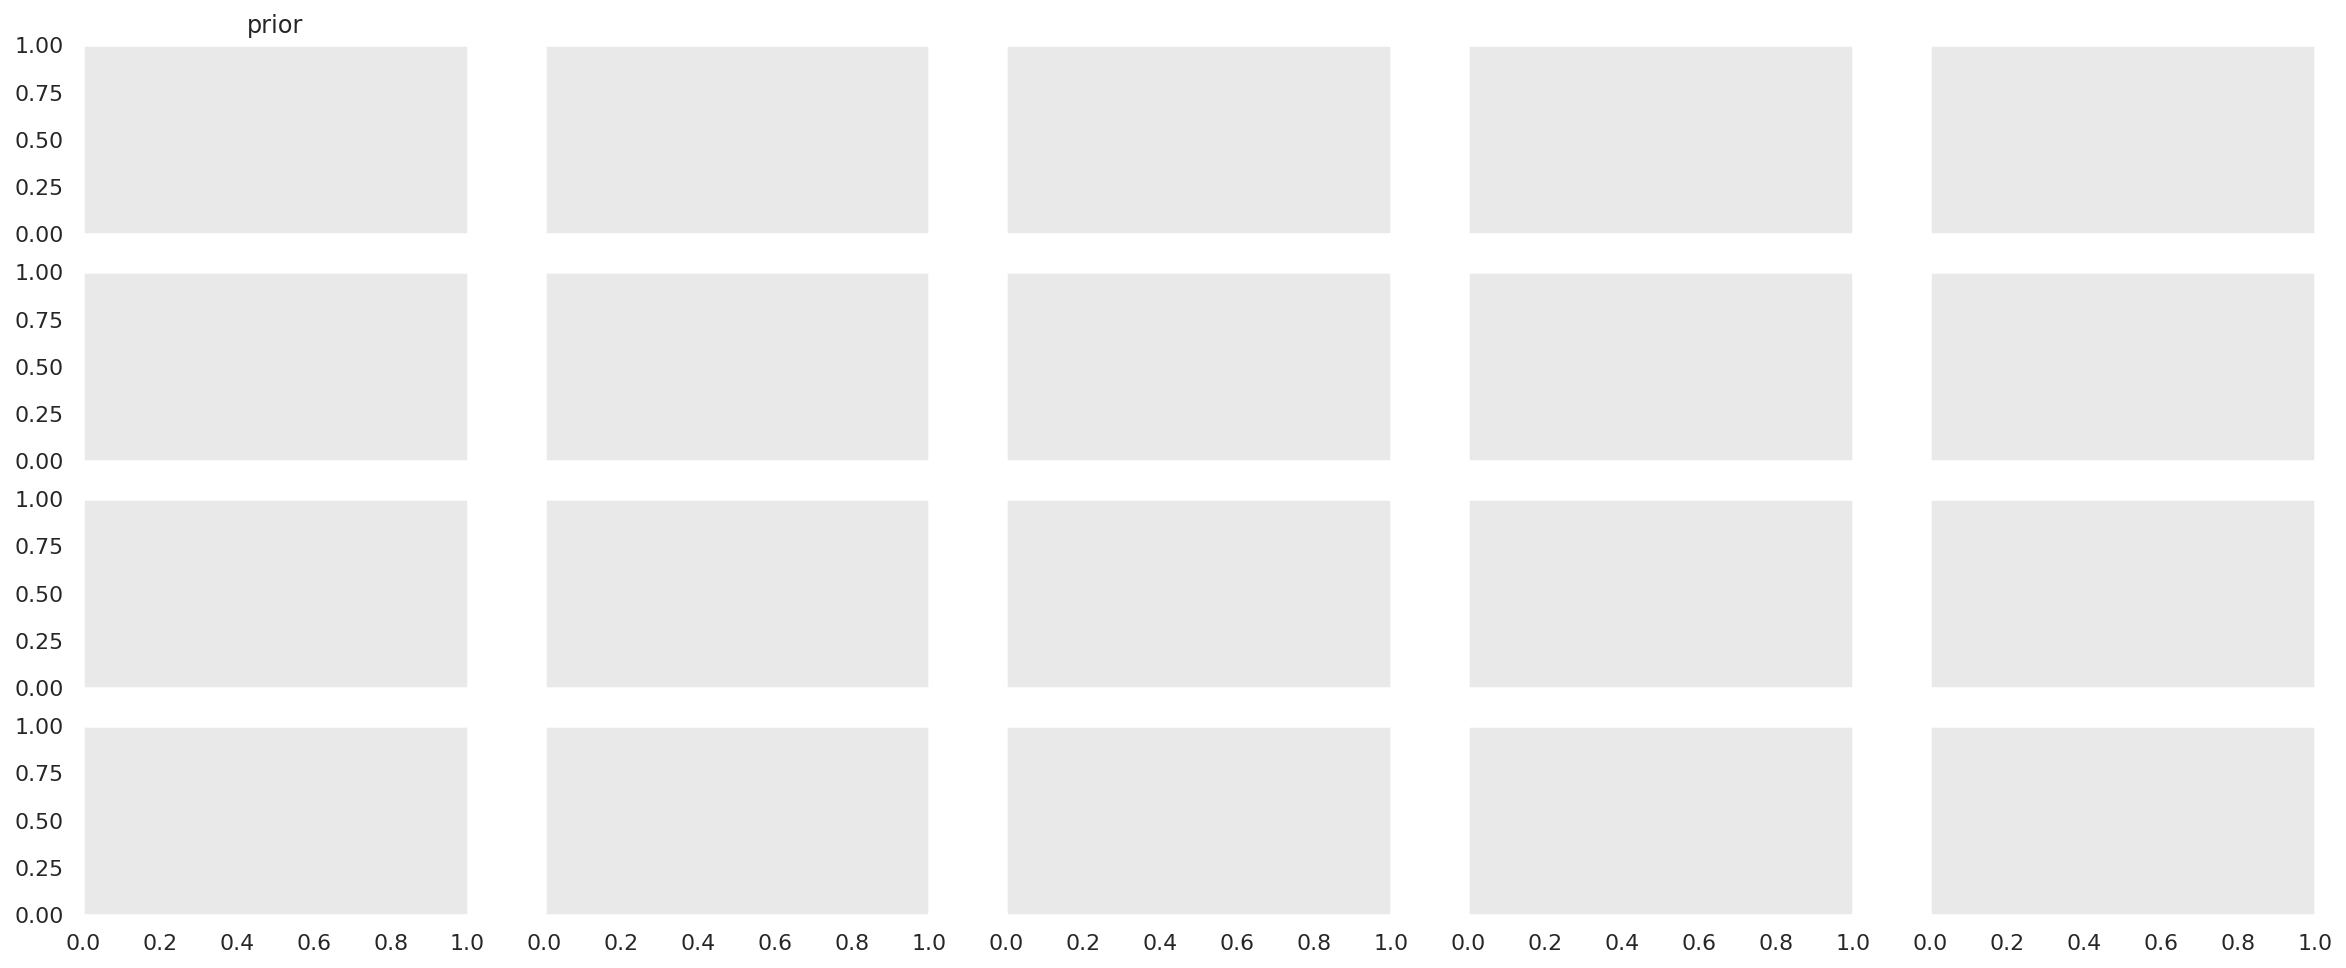

In [80]:
ncols=5
nrows=4

colors = ['red', 'green', 'pink', 'lightblue', 'orange', 'yellow', 'black']
c_dict = {o:colors[i] for i, o in enumerate(list(set(opt_techniques)))}

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 8), sharex=True, sharey=True)

for g in range(G):
    group_name = group_names[g]
    opt = opt_techniques[g]
    row, col = g // ncols, g % ncols
    axs[row, col].set_title(group_name)
    axs[row, col].plot(x.flatten().numpy(), density_values[g].flatten().numpy(), c_dict[opt])
    
plt.tight_layout()

In [ ]:
ncols=5
nrows=4

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))

for g in reversed(range(G)):
    group_name = group_names[g]
    opt = opt_techniques[g]
    tr = target_rates[g]
    row, col = g // ncols, g % ncols
    #ax.set_title(group_name)
    if (tr < 0.2):
        ax.plot(x.flatten().numpy(), density_values[g].flatten().numpy(), c_dict[opt], label=opt)
    else:
        ax.plot(x.flatten().numpy(), density_values[g].flatten().numpy(), c_dict[opt])

plt.legend()
plt.tight_layout()
plt.title("Fitted groups for different optimisation techniques with different target rates")

In [31]:
z = td.Categorical(probs=omega).sample()
z.shape

torch.Size([1000, 19])

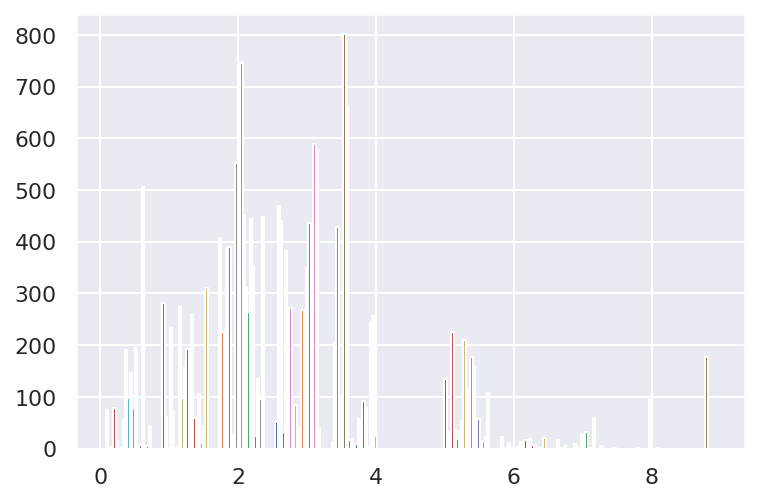

In [32]:
_ = plt.hist(z.detach().cpu().numpy(), bins=cfg.T+1)

In [33]:
post_mu = (posterior["mu"] *  torch.nn.functional.one_hot(z, cfg.T).unsqueeze(-1)).sum(-2)  #[z].shape
post_mu.shape

torch.Size([1000, 19, 1])

In [34]:
post_scale = (posterior["diag"] *  torch.nn.functional.one_hot(z, cfg.T).unsqueeze(-1)).sum(-2)  #[z].shape
post_scale.shape

torch.Size([1000, 19, 1])

In [35]:
import arviz

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

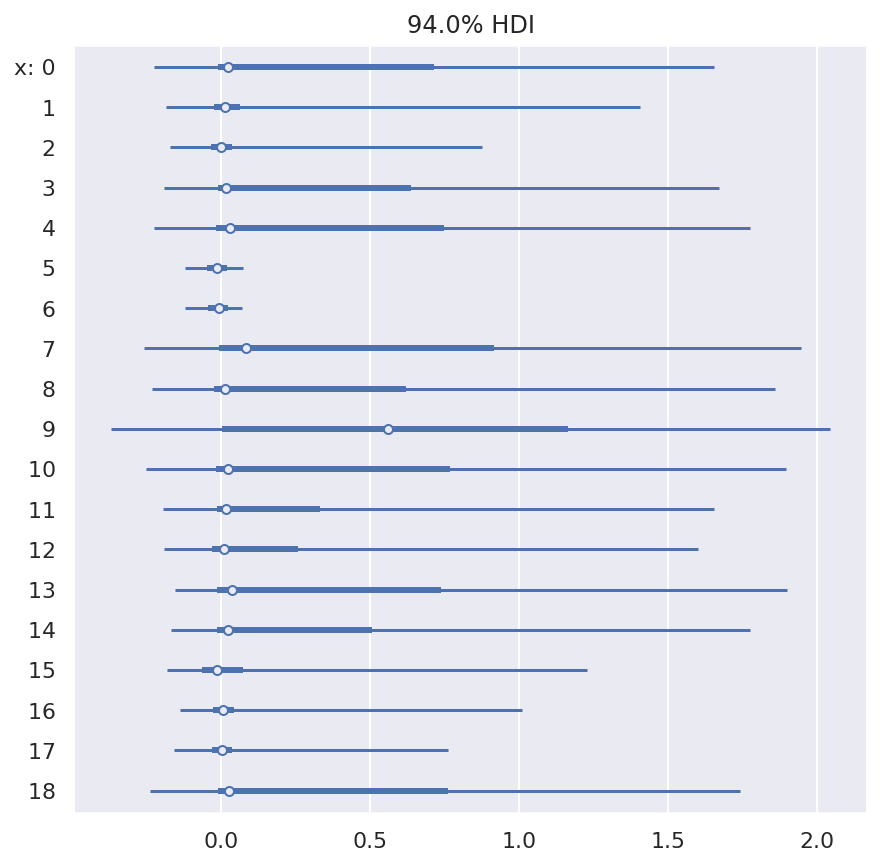

In [36]:
arviz.plot_forest(
    post_mu.permute([2, 0, 1]).detach().cpu().numpy()
    #kind='ridgeplot'
)

array([<AxesSubplot:>], dtype=object)

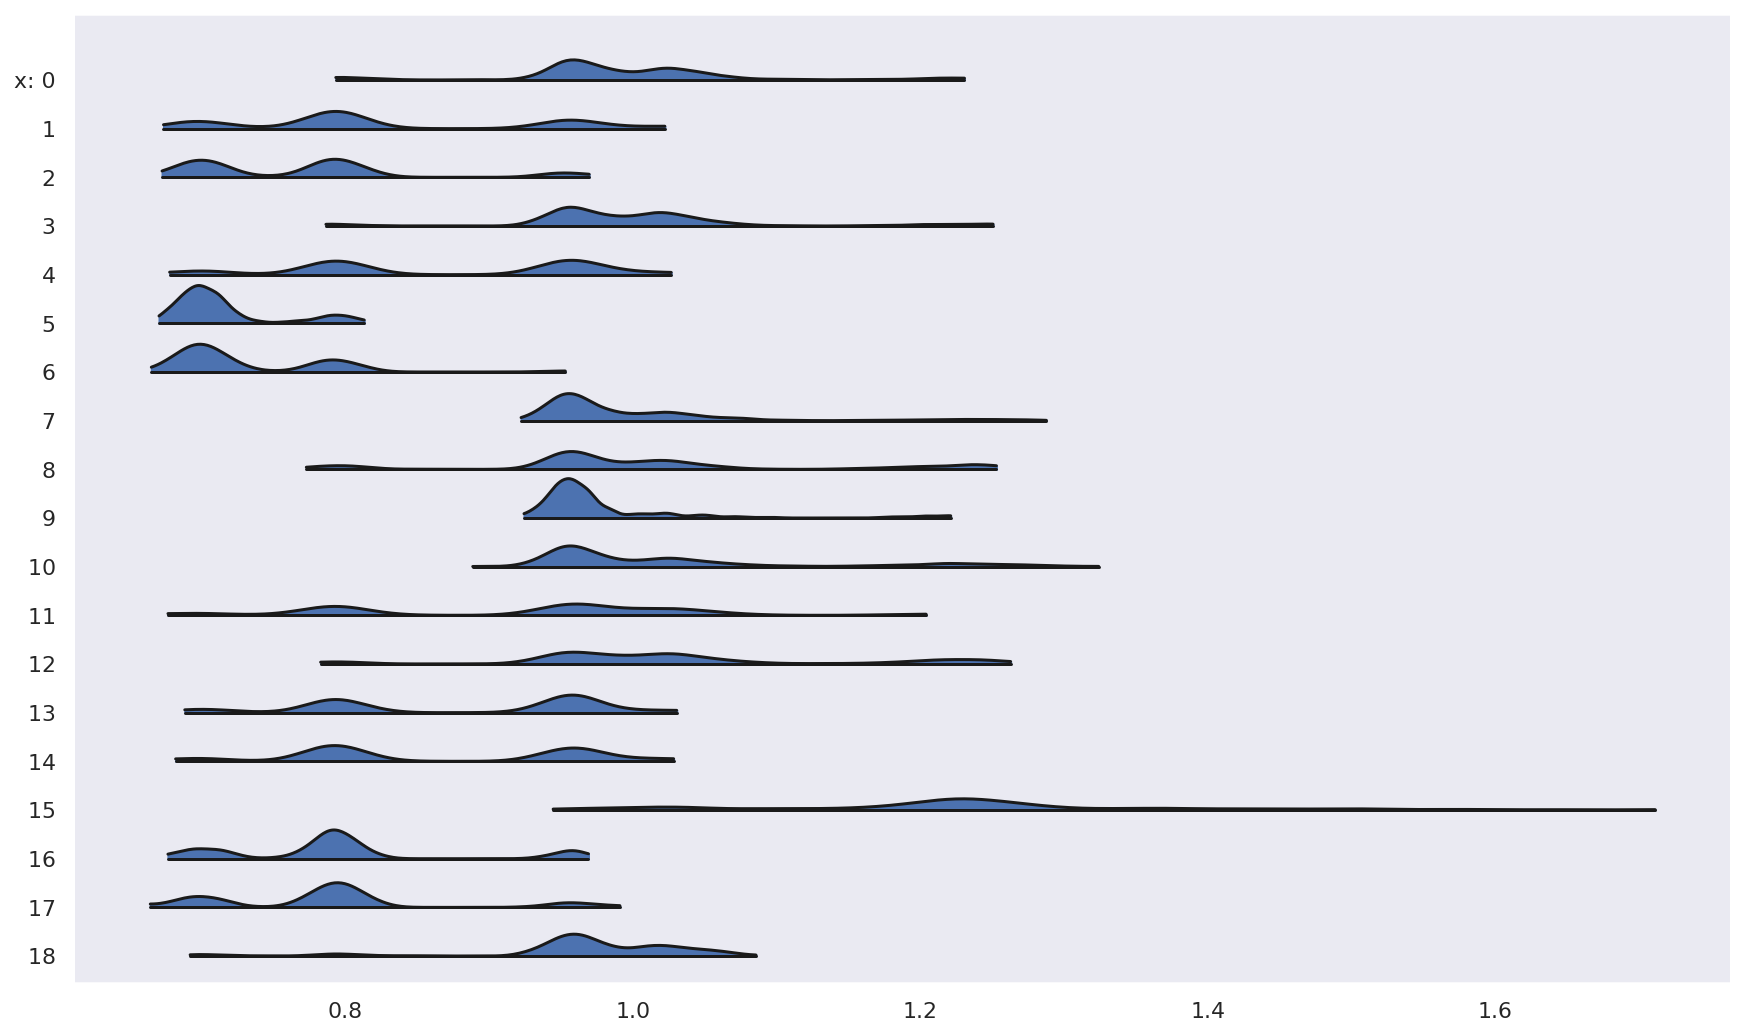

In [37]:
arviz.plot_forest(
    post_scale.permute([2, 0, 1]).detach().cpu().numpy(),
    kind='ridgeplot'
)

In [38]:
post_nu = (posterior["nu"] *  torch.nn.functional.one_hot(z, cfg.T).unsqueeze(-1)).sum(-2)  #[z].shape
post_nu.shape

torch.Size([1000, 19, 1])

array([<AxesSubplot:>], dtype=object)

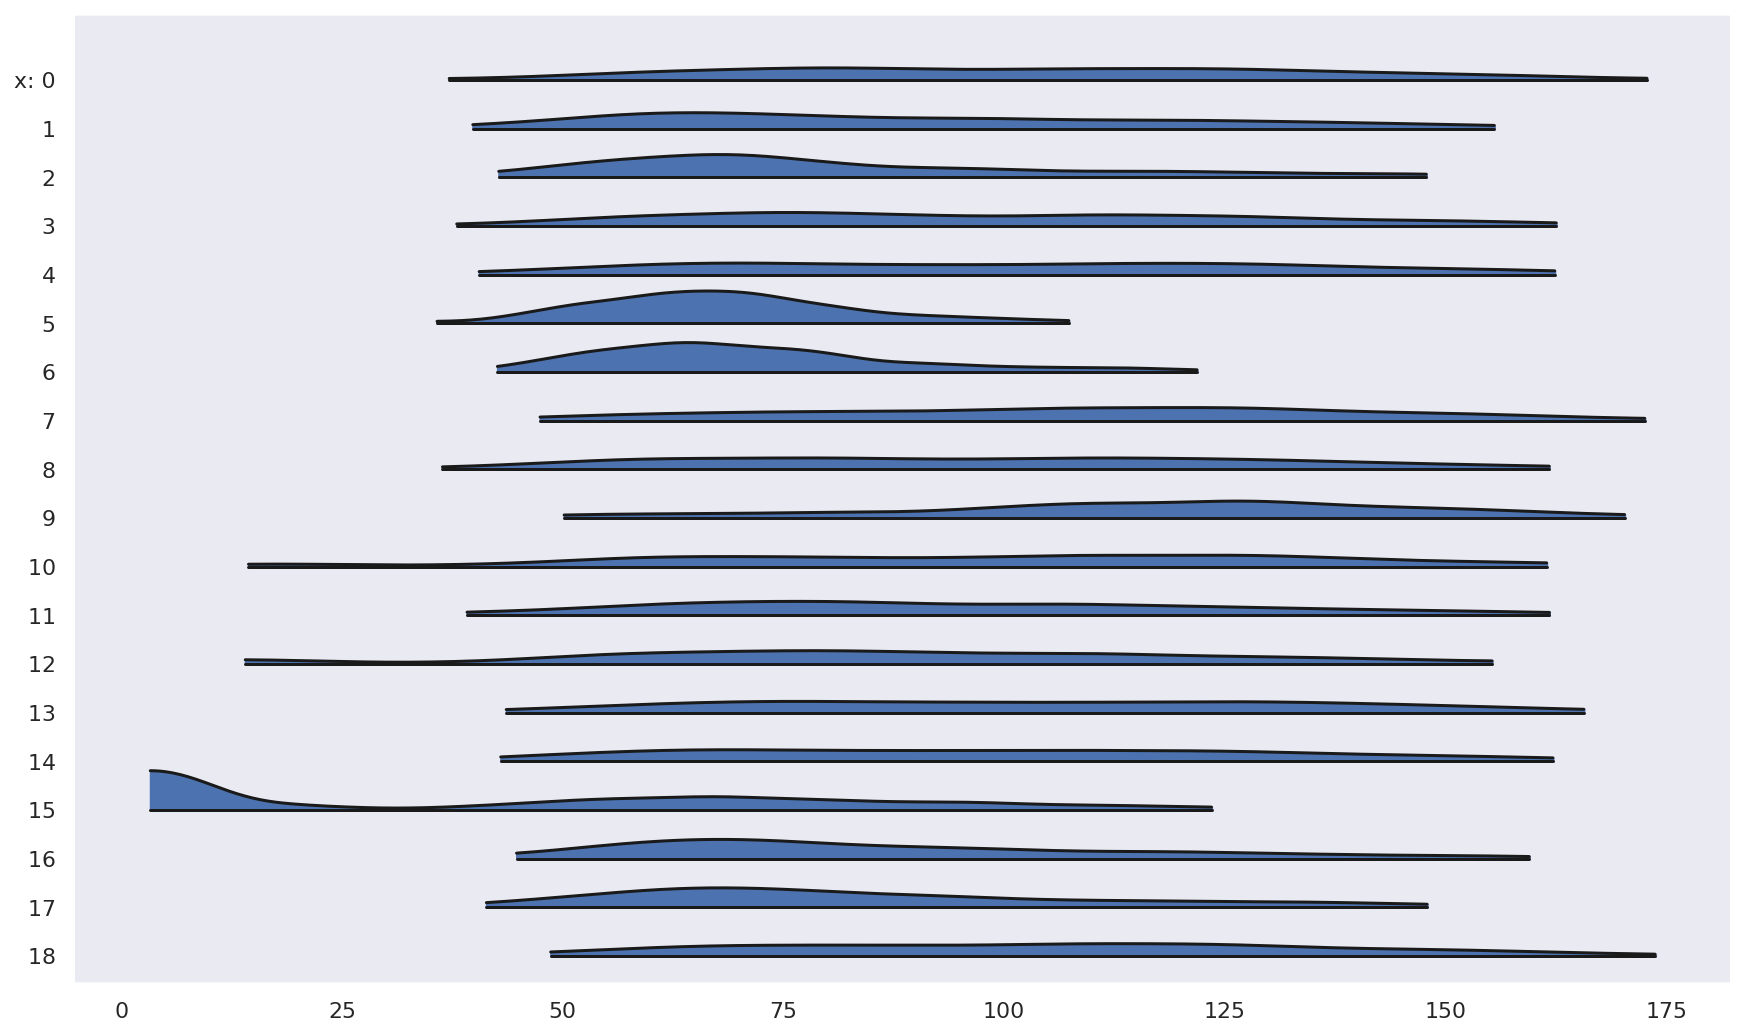

In [39]:
arviz.plot_forest(
    post_nu.permute([2, 0, 1]).detach().cpu().numpy(),
    kind='ridgeplot'
)